First we will import the necessary libraries for this exercise, which will be numpy for the calculations, timeit to check the speed of each method, gc to help us with the timing, and matplotlib to plot it visually.

In [30]:
import numpy as np
import timeit
import gc
import matplotlib.pyplot as plt

Now we are going to implement the main function, TridiagonalSolver,
and for that we will first look again at what is being asked:

![alt text](exercise_1_-1.png)


Remember: a tridiagonal system is a special type of linear system where the coefficient matrix has non-zero elements only on the main diagonal, the first diagonal below this, and the first diagonal above the main diagonal.

The algorithm is divided into two main steps: forward elimination and backward substitution. We start by creating copies of the input arrays to avoid modifying the original ones. Then, we proceed with the forward elimination step to transform the original tridiagonal matrix into an upper triangular matrix. Finally, we perform backward substitution to obtain the solution vector.

Tip: the algorithm asked is Thomas algorithm!

In [31]:
def TridiagonalSolver(d, o, u, r):
    n = len(d)
    d = np.copy(d)
    r = np.copy(r)
    o = np.copy(o)
    u = np.copy(u)
    
    # Forward elimination
    for i in range(1, n):
        w = u[i-1]/d[i-1]
        d[i] -= w*o[i-1]
        r[i] -= w*r[i-1]
    
    # Backward substitution
    x = np.zeros(n)
    x[-1] = r[-1]/d[-1]
    for i in range(n-2, -1, -1):
        x[i] = (r[i]-o[i]*x[i+1])/d[i]
    return x

For more information into the exact specific algorithms, see ``Numerical Methods in Matrix Computations'', by Åke Björck, section 1.2.


Next, we will create random matrices of different sizes, and using the library time, we will track how efficient this method is. Notwithstanding, we will add to the comparison the library numpy.lingalg.inv, and np.linalg.solve.


Numpy.linalg.inv gives us the inverse of a matrix, and allows us to compute the solution using $$\bold{x}=\bold{A}^{-1}\bold{b}$$.

On the other side, np.linalg.solve gives us directly the solution of $$\bold{A}\bold{x} = \bold{b}$$

We will see how these three different algorithms compare in terms of speed, and why (e.g. what time complexity O(?) do they have).

To see all of that, let's first define a function to generate random tridiagonal systems:

In [32]:
# Function to generate random tridiagonal systems
def generate_tridiagonal_system(n):
    d = np.random.rand(n)
    o = np.random.rand(n-1)
    u = np.random.rand(n-1)
    r = np.random.rand(n)
    return d, o, u, r

Following we define the final function:
- We start by defining the size we want to test the algorithms up to, by creating a np.arange. In addition, we create an empty list for each algorithm we have where we will fill the time taken for a certain matrix size.
- To check the time, we will first remove any possible background noise in terms of memory and CPU allocation in a couple of ways:
    1. Locally, ensuring that no other program is running along and using memory and CPU.
    2. By disabling the garbage collector in python for the section where we take our measurements (see more on https://docs.python.org/3/library/gc.html)
    3. By taking an average of the computation time, repeating it, and taking the minimum (see https://stackoverflow.com/questions/8220801/how-to-use-timeit-module as to why the minimum).

To ensure this, we will use the gc and timeit Python libraries:

In [36]:
def measure_time_and_solve():
    sizes = np.arange(10, 501, 1)
    # We start at a 10x10 matrix and increase the size 1 by 1 until 500
    thomas_times = []
    inv_times = []
    solve_times = []
    
    repetitions = 10

    for size in sizes:
        d, o, u, r = generate_tridiagonal_system(size)
        A = np.diag(d) + np.diag(o, k=1) + np.diag(u, k=-1)
        # Thanks Numpy for this awesome way of building a tridiagonal matrix!
        
        # Disable garbage collection
        gc.disable()
        
        # Measure time for TridiagonalSolver
        thomas_timer = timeit.Timer(lambda: TridiagonalSolver(d, o, u, r))
        thomas_time = min(thomas_timer.repeat(repeat=5, number=repetitions))/repetitions
        thomas_times.append(thomas_time)

        # Measure time for numpy.linalg.inv
        inv_timer = timeit.Timer(lambda: np.linalg.inv(A))
        inv_time = min(inv_timer.repeat(repeat=5, number=repetitions))/repetitions
        inv_times.append(inv_time)
        
        # Measure time for numpy.linalg.solve
        solve_timer = timeit.Timer(lambda: np.linalg.solve(A, r))
        solve_time = min(solve_timer.repeat(repeat=5, number=repetitions))/repetitions
        solve_times.append(solve_time)
        
        # Enable garbage collection
        gc.enable()
    
    return sizes, thomas_times, inv_times, solve_times

Finally, we create a plotting function, and we execute our code:

In [37]:
# Plotting the results
def plot_results(sizes, thomas_times, inv_times, solve_times):
    plt.plot(sizes, thomas_times, label='Thomas Algorithm')
    plt.plot(sizes, inv_times, label='Numpy Inv')
    plt.plot(sizes, solve_times, label='Numpy Solve')
    plt.xlabel('Matrix Size')
    plt.ylabel('Calculation Time (s)')
    plt.legend()
    plt.title('Calculation Time vs Matrix Size')
    plt.show()

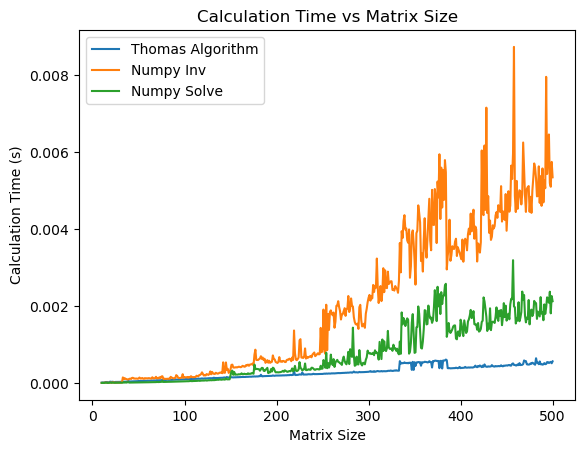

In [38]:
sizes, thomas_times, inv_times, solve_times = measure_time_and_solve()
plot_results(sizes, thomas_times, inv_times, solve_times)

The result should be something similar to this:

![alt text](exercise_1_3.png)

Looks quite neat, right? 

First of all, you may see that even though we tried to minimize noise, it is still there, and from personal tests, I can assure (but cannot find out the reason) that both numpy methods have way more noise that the function we just built.

Now, to the juicy part: what is behind the difference in calculation time? What is the time complexity of each algorithm?

As may be visible in the graph, our custom function is way more efficient than the other Numpy algos. In fact, our function has a time complexity of $O(n)$, compared to $O(n^3)$ of the Numpy algorithms. Now, if both algorithms are asymptotically equally in calculation time, why are they so different? The answer to this comes really naturally: notice that to solve the system with numpy.linalg.inv we have to first inverse a matrix (if it even works, as it may be unstable!) and then solve a system of linear equations. Furthermore, it is pretty clear that numpy.linalg.inv should be slower than numpy.linalg.solve, as the latter is specifically optimized to do what we are trying to do, and involves fewer steps.

Now, why would numpy.linalg.solve be way slower than our method? Isn't numpy methods suposed to be optimized and be state of the art? Well, yes, but they also offer more flexibility! 

Our function is faster because our function is specific $\bold{to\:tridiagonal \:matrices}$. numpy.linalg.solve uses a general algorithm, that applies to every type of matrix.

With this we conclude this exercise, and we learn with it how to efficiently solve a tridiagonal (also called sparse) system of linear equations.